# 33-241 Final Project
# Nico Ortiz de Zárate

## Modules

In [1]:
# Python
from datetime import datetime

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy        as np
import numpy.random as random
from numpy import cos, exp, log, pi, sin, sqrt

# Scipy
import scipy.linalg as linalg
import scipy.fft as fft
import scipy.stats as stats

## N-body Simulations

### One particle Test

In [2]:
def oneParticleTest():
    # Initialize particles array and time for the one particle test
    particles = np.zeros((Np, 9)) # Empty initial particles
    particles = Init(particles, Np) # Random placed particles
    density = initDensity(particles, Nc)
    wk = gravKernel(density) # Saved gravitational kernel
    phi = potentialSolver(density, wk) # Potential field solver
    phiTest(particles, phi) # one particle test for potential
    f = forceFieldSolver(phi, l) # Force field solver
    forceFieldTest(particles, f, Nc) # Force field test for one particle
    particles = accelerationInterp(f, particles, l) # Interpolate accelerations for particles
    

### Density Field

In [3]:
def findIndexLoc(x, y, z, l):
    # Find the index location given a cartesian coord. x,y,z and cell length l
    i = int(x//l)
    j = int(y//l)
    k = int(z//l)
    return i,j,k

def findCellBounds(i1,j1,k1, l):
    xBound = (i1+1)*l
    yBound = (j1+1)*l
    zBound = (k1+1)*l
    return xBound, yBound, zBound

def deltaX(x, xBound, l):
    # Calculate and return x overlap
    dx1 = abs((x-l/2) - xBound)
    dx2 = abs((x+l/2) - xBound)
    return dx1, dx2

def deltaY(y, yBound, l):
    # Calculate and return y overlap
    dy1 = abs((y-l/2) - yBound)
    dy2 = abs((y+l/2) - yBound)
    return dy1, dy2

def deltaZ(z, zBound, l):
    # Caluclate and return z overlap
    dz1 = abs((z-l/2) - zBound)
    dz2 = abs((z+l/2) - zBound)
    return dz1, dz2

def assignMass(mp, l, dx, dy, dz):
    # calculate and return mass assigned to the corresponding overlapping amount
    mass = mp*(dx*dy*dz)/(l**3)
    return mass

def assignDensity(density, deltas, indices, l):
    dX, dY, dZ = deltas
    I, J, K = indices
    # loop over all combos of mass assignments and assign corresponding density
    for a in range(len(I)):
        i = I[a]
        for b in range(len(J)):
            j = J[b]
            for c in range(len(K)):
                k = K[c]
                # Ignore cells outside of bounds
                if(i>=Nc or j>=Nc or k>=Nc or i<=-Nc or j<=-Nc or k<=-Nc): continue
                mass = assignMass(mp, l, dX[a], dY[b], dZ[c])
                density[i,j,k] += mass/(l**3)
    return density

def initDensity(particles, Nc):
    l = L/Nc # length of side of a cell
    density = np.zeros((Nc, Nc, Nc))
    # Loop over each particle
    for particle in particles:
        x, y, z = particle[0], particle[1], particle[2] # Cartesian coord. of particle
                
        # Find index location of overlapping cells
        i1, j1, k1 = findIndexLoc(x-l/2, y-l/2, z-l/2, l)
        i2, j2, k2 = findIndexLoc(x+l/2, y+l/2, z+l/2, l)
        
        # Get cell boundaries and calculate amount of overlap
        xBound, yBound, zBound = findCellBounds(i1, j1, k1, l)
        dx1, dx2 = deltaX(x, xBound, l)
        dy1, dy2 = deltaY(y, yBound, l)
        dz1, dz2 = deltaZ(z, zBound, l)
        
        #Assign mass densities
        deltas = ((dx1, dx2), (dy1, dy2), (dz1, dz2))
        indices = ((i1, i2), (j1, j2), (k1, k2))
        density = assignDensity(density, deltas, indices, l)
    
    return density


### Gravitational Kernel

In [4]:
def gravKernel(density):
    # Given density in real space, calculate forward fft to rhoK, get dimensions of wk
    rhoK = fft.rfftn(density)
    Nkx, Nky, Nkz = rhoK.shape
    Nk = Nkx
    
    # initialize wk and then Loop 
    wk = np.zeros((Nkx, Nky, Nkz))
    for i in range(Nkx):
        # Determine kx
        if(i <= Nk//2 + 1):
            kx = (2*np.pi*i)/Nk
        else: 
            kx = (2*np.pi*(i-Nk))/Nk
        for j in range(Nky):
            # Determine ky
            if(j <= Nk//2 + 1):
                ky = (2*np.pi*j)/Nk
            else: 
                ky = (2*np.pi*(j-Nk))/Nk
            for k in range(Nkz):
                # Determine kz
                kz = (2*np.pi*k)/Nk
                # Calculate w(k)
                if(i==0 and j==0 and k==0):
                    wk[i,j,k] == 0
                else:
                    wk[i,j,k] = -(4*np.pi*G)/((2*sin(kx/2))**2 + (2*sin(ky/2))**2 + (2*sin(kz/2))**2)
    return wk

### Gravitational Potential

In [5]:
def potentialSolver(density, wk):
    # Takes in a density field in real space and gravitational kernel in Fourier space

    # Forward FFT the density field to Fourier space
    rhoK = fft.rfftn(density)
    
    # Multiply density field and gravitational kernel to get potential in Fourier space
    phiK = rhoK*wk
    
    # Inverse FFT phiK to get potential in real space
    phi = fft.irfftn(phiK)*(L/Nc)**2
    
    return phi

def phiTest(particles, phi):
    px, py, pz = particles[0,0], particles[0,1], particles[0,2] # position of particle
    r = np.zeros((Nc, Nc, Nc))  # position array
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                x, y, z = findCartesianLoc(i, j, k, l) # center of cell in cartesian
                r[i,j,k] = ((x-px)**2 + (y-py)**2 + (z-pz)**2)**0.5 # distance r from particle
    
    
    rpoints = np.linspace(l, L, 100)
    # plot
    #scatter points of phi
    plt.scatter(r, phi)
    plt.plot(rpoints, (-G*mp)/rpoints, 'k')
    #slice of potential
    #plt.plot(phi[:,Nc//2,Nc//2])
    plt.title('One Particle Potential Test')
    plt.xlabel('r [m]')
    plt.ylabel('Potential')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.show()

### Gravitational Force

In [6]:
def delX(phi, i, j, k, x, l):
    # If near border, forward/backward difference
    if(i == 0):
        return -(phi[i+1,j,k] - phi[i,j,k])/l
    elif(i == x-1):
        return -(phi[i,j,k] - phi[i-1,j,k])/l
    # Else, central difference
    else: 
        return -(phi[i+1,j,k] - phi[i-1,j,k])/(2*l)
    
def delY(phi, i, j, k, y, l):
    # If near border, forward/backward difference
    if(j == 0):
        return -(phi[i,j+1,k] - phi[i,j,k])/l
    elif(j == y-1):
        return -(phi[i,j,k] - phi[i,j-1,k])/l
    # Else, central difference
    else: 
        return -(phi[i,j+1,k] - phi[i,j-1,k])/(2*l)

def delZ(phi, i, j, k, z, l):
    # If near border, forward/backward difference
    if(k == 0):
        return -(phi[i,j,k+1] - phi[i,j,k])/l
    elif(k == z-1):
        return -(phi[i,j,k] - phi[i,j,k-1])/l
    # Else, central difference
    else: 
        return -(phi[i,j,k+1] - phi[i,j,k-1])/(2*l)

def forceFieldSolver(phi, l):
    # Finite difference the potential field to get the force field
    
    # Loop over potential field phi
    x, y, z = phi.shape
    f = np.zeros((x, y, z, 3))
    for i in range(x):
        for j in range(y):
            for k in range(z):
                # finite difference phi and calculate for field
                fx = delX(phi, i, j, k, x, l)
                fy = delY(phi, i, j, k, y, l)
                fz = delZ(phi, i, j, k, z, l)
                
                # 3D array holding tuples with forces
                f[i,j,k] = ((fx, fy, fz))
    
    return f

def findCartesianLoc(i, j, k, l):
    x, y, z = (i+0.5)*l, (j+0.5)*l, (k+0.5)*l
    return x, y, z

def forceFieldTest(particles, f, Nc):
    px, py, pz = particles[0,0], particles[0,1], particles[0,2] # position of particle
    r = np.zeros((Nc, Nc, Nc))  # position array
    force = np.zeros((Nc, Nc, Nc)) # store magnitude of forces
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                x, y, z = findCartesianLoc(i, j, k, l) # center of cell in cartesian
                r[i,j,k] = ((x-px)**2 + (y-py)**2 + (z-pz)**2)**0.5 # distance r from particle
                fx, fy, fz = f[i,j,k] # get values for components of force
                force[i,j,k] = (fx**2 + fy**2 + fz**2)**0.5 # store magnitude of force
    
    # plot
    rpoints = np.linspace(l, L, 1000)
    plt.scatter(r, force)
    plt.plot(rpoints, (G*mp)/rpoints**2, 'k')
    plt.title('One Particle Force Test')
    plt.xlabel('r [m]')
    plt.ylabel('Force [N]')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

## Acceleration Interpolation

In [7]:
def assignAcceleration(particle, f, deltas, indices, l):
    # Assign acceleration per cell based off of force field 
    dX, dY, dZ = deltas
    I, J, K = indices
    # loop over all combos and assign corresponding accelerations
    for a in range(len(I)):
        i = I[a]
        for b in range(len(J)):
            j = J[b]
            for c in range(len(K)):
                k = K[c]
                # Ignore cells outside of bounds
                if(i>=Nc or j>=Nc or k>=Nc or i<=-Nc or j<=-Nc or k<=-Nc): continue
                # force field components at given i,j,k
                fx, fy, fz = f[i,j,k] 
                # add x, y, and z acceleration components
                ax = fx*(dX[a]*dY[b]*dZ[c])/(l**3)
                ay = fy*(dX[a]*dY[b]*dZ[c])/(l**3)
                az = fz*(dX[a]*dY[b]*dZ[c])/(l**3)
                
                # Add to particle acceleration
                particle[6] += ax
                particle[7] += ay
                particle[8] += az
    
    return particle

def accelerationInterp(f, particles, l):
    # Interpolate the accelerations of each particle
    for particle in particles:
        x, y, z = particle[0], particle[1], particle[2] # Cartesian coord. of particle
                
        # Find index location of overlapping cells
        i1, j1, k1 = findIndexLoc(x-l/2, y-l/2, z-l/2, l)
        i2, j2, k2 = findIndexLoc(x+l/2, y+l/2, z+l/2, l)
        
        # Get cell boundaries and calculate amount of overlap
        xBound, yBound, zBound = findCellBounds(i1, j1, k1, l)
        dx1, dx2 = deltaX(x, xBound, l)
        dy1, dy2 = deltaY(y, yBound, l)
        dz1, dz2 = deltaZ(z, zBound, l)
        
        #Assign acceleration per cell
        deltas = ((dx1, dx2), (dy1, dy2), (dz1, dz2))
        indices = ((i1, i2), (j1, j2), (k1, k2))
        particle = assignAcceleration(particle, f, deltas, indices, l)
    
    return particles

## Many-Body Problem

### Mass and Acceleration Plots

In [8]:
def distanceFromCenter(partX, partY, partZ):
    # Returns particle distance from center of sphere given particle location in mesh
    r = ((partX-L/2)**2 + (partY-L/2)**2 + (partZ-L/2)**2)**0.5
    return r
    
def massProfileVisualizer(particles, tCurrent):
    
    r = np.empty(Np)
    for i in range(Np):
        particle = particles[i]
        partX, partY, partZ = particle[0], particle[1], particle[2]
        r[i] = distanceFromCenter(partX, partY, partZ)
    
    #Visualize mass profile
    totalMass = len(particles)*mp
    rpoints = np.linspace(0, L/4, 1000)
    res = stats.cumfreq(r, numbins=Np)
    x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
    massProfile = res.cumcount*mp
    plt.bar(x, massProfile, width=res.binsize)
    plt.plot(rpoints, totalMass*(rpoints/R)**3, 'k', label='mass profile theory for t=0')
    plt.title('Mass profile M(r) at t/tDynamical = ' + str(tCurrent))
    plt.xlabel('r [m]')
    plt.ylabel('Mass [kg]')
    plt.legend()
    plt.show()
    
    return massProfile

def accelerationProfileVisualizer(particles, massProfile, tCurrent):
    r = np.zeros(Np)
    aMag = np.zeros(Np)
    for i in range(Np):
        # Calculate accleration of particle at distance r from center of sphere
        particle = particles[i]
        partX, partY, partZ = particle[0], particle[1], particle[2] # particle positions
        partAx, partAy, partAz = particle[6], particle[7], particle[8] # particles accelerations
        aMag[i] = (partAx**2 + partAy**2 + partAz**2)**0.5 # magnitude of acceleration of particle
        r[i] = distanceFromCenter(partX, partY, partZ) # magnitude of distance from center of sphere
    
    # Plot 
    rpoints = np.linspace(l, L/4, Np)
    plt.scatter(r, aMag)
    plt.plot(rpoints, (G*massProfile)/rpoints**2, 'k', label="acceleration profile theory")
    plt.title('Acceleration Profile over distance r at t/tDynamical = ' + str(tCurrent))
    plt.xlabel('r [m]')
    plt.ylabel('a [m/s^2]')
    plt.legend()
    plt.show()
    
        

### Initial Conditions

In [9]:

# Transformation functions
def rTransformation(N):
    return R*N**(1/3)

def thetaTransformation(N):
    return np.arccos(1-2*N)

def phiTransformation(N):
    return 2*np.pi*N

def findCartLoc(i, r, theta, phi):
    # find and return cartesian location of center of cell for a given index i
    x = r[i]*sin(theta[i])*cos(phi[i]) + L/2
    y = r[i]*sin(theta[i])*sin(phi[i]) + L/2
    z = r[i]*cos(theta[i]) + L/2
    return x, y, z

def Init(particles, Np):
    random.seed(10)
    # Generate random numbers in spherical coordinates
    Nr = random.rand(Np)
    Ntheta = random.rand(Np)
    Nphi = random.rand(Np)
    
    r = rTransformation(Nr)
    theta = thetaTransformation(Ntheta)
    phi = phiTransformation(Nphi)

    # x, y, z arrays for plotting check
    X, Y, Z = np.empty(Np), np.empty(Np), np.empty(Np)
    # Convert back to cartesian coordinates and store particle positions
    for i in range(Np):
        x, y, z = findCartLoc(i, r, theta, phi)
        
        particles[i,0], particles[i,1], particles[i,2] = x, y, z
        X[i], Y[i], Z[i] = x, y, z
    
    
    # Plot
    plt.figure()
    plt.title('Initial conditions for particles')
    plt.scatter(X, Y, s=2)
    plt.xlabel('x')
    plt.ylabel('y ')
    #plt.scatter(Y, Z, s=2)
    #plt.xlabel('y')
    #plt.ylabel('z ')
    plt.axis('square')
    plt.axis([0.0,1.0,0.0,1.0])
    plt.show()
    
    return particles

## Gravity Solver

In [10]:
def gravitySolver(particles):
    density = initDensity(particles, Nc)
    wk = gravKernel(density) # Saved gravitational kernel
    phi = potentialSolver(density, wk) # Potential field solver
    f = forceFieldSolver(phi, l) # Force field solver
    particles = accelerationInterp(f, particles, l) # Interpolate accelerations for particles
    return particles


## Newton Equations Solver/Time Integration

In [11]:
def vMax(particles):
    # Calculates the maximum velocity in the particles list
    vmax = -1
    for particle in particles:
        vx, vy, vz = particle[3], particle[4], particle[5]
        v = (vx**2 + vy**2 + vz**2)**0.5
        if v > vmax: vmax = v
    return vmax

def aMax(particles):
    # Calculates the maximum acceleration
    amax = -1
    for particle in particles:
        ax, ay, az = particle[6], particle[7], particle[8]
        a = (ax**2 + ay**2 + az**2)**0.5
        if a > amax: amax = a
    return amax

def dkd(particles, dt):
    # Drift kick drift 
    particles[:,:3]  += particles[:,3:6]*dt/2
    particles = gravitySolver(particles)
    particles[:,3:6] += particles[:,6:]*dt
    particles[:,:3]  += particles[:,3:6]*dt/2
    
    return particles

def xyVisualizer(particles, tCurrent):
    # Calculate and plot the x and y positions
    xPart, yPart = np.zeros(Np), np.zeros(Np)
    for i in range(Np):
        particle = particles[i]
        x, y = particle[0], particle[1]
        xPart[i] = x
        yPart[i] = y
        
    # Plot
    color = np.arange(Np)
    plt.scatter(xPart, yPart, s=2, c=color, cmap='inferno')
    plt.title('x-y Particle Positions at t/tDynamical = ' + str(tCurrent))
    plt.xlabel('x [m]')
    plt.xlim(0, 1)
    plt.ylabel('y [m]')
    plt.ylim(0, 1)
    cb = plt.colorbar()
    cb.ax.set_ylabel('Particle')
    plt.show()

def yzVisualizer(particles, tCurrent):
    # Calculate and plot the y and z positions
    color = np.arange(Np) # Color code based on distance from center
    yPart, zPart = np.zeros(Np), np.zeros(Np)
    for i in range(Np):
        particle = particles[i]
        y, z = particle[1], particle[2]
        yPart[i] = y
        zPart[i] = z
        
    # Plot
    plt.scatter(yPart, zPart, s=2, c=color, cmap='inferno')
    plt.title('y-z Particle Positions at t/tDynamical = ' + str(tCurrent))
    plt.xlabel('y [m]')
    plt.xlim(0, 1)
    plt.ylabel('z [m]')
    plt.ylim(0, 1)
    cb = plt.colorbar()
    cb.ax.set_ylabel('Particle')
    plt.show()

def visualize(particles, tCurrent):
    xyVisualizer(particles, tCurrent)
    yzVisualizer(particles, tCurrent)
    massProfile = massProfileVisualizer(particles, tCurrent)
    accelerationProfileVisualizer(particles, massProfile, tCurrent)
    

def NewtonSolver(t0, tDynamical):
    # Initialize particles array and time
    particles = np.zeros((Np, 9)) # Empty initial particles
    particles = Init(particles, Np) # Random placed particles
    particles = gravitySolver(particles) # Initial gravity solver for particles
    visualize(particles, t0) # Visualize initial conditions
    
    # Time integration
    t = 0.0
    tStep = 0.0
    while t/tDynamical < 1:
        # Calculate the adaptive time step
        vmax, amax = vMax(particles), aMax(particles)
        dt = lamnda*(min(l/vmax, (l/amax)**0.5)) 
        
        # Do not calc initial time conditions again
        if t/tDynamical == 0.0: 
            t += dt
            continue
        
        # Time step
        particles = dkd(particles, dt)
        
        # Check if at snapshot time, and if so, produce graphs
        tCurrent = t/tDynamical
        if(tCurrent >= tStep):
            visualize(particles, tCurrent)
            tStep += 0.05
        # Progress time     
        t += dt
    # Last iteration when t/tDynamical is > 1
    vmax, amax = vMax(particles), aMax(particles)
    dt = lamnda*(min(l/vmax, (l/amax)**0.5)) 

    # Time step
    particles = dkd(particles, dt)

    # Check if at snapshot time, and if so, produce graphs
    tCurrent = t/tDynamical
    if(tCurrent >= tStep):
        visualize(particles, tCurrent)


## Results

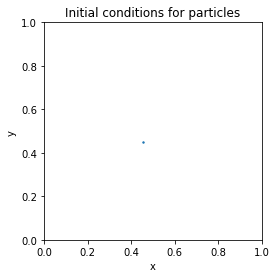

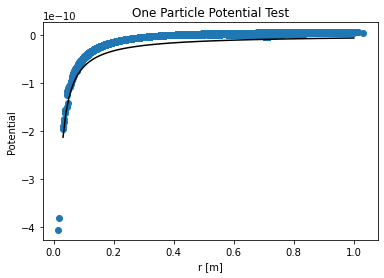

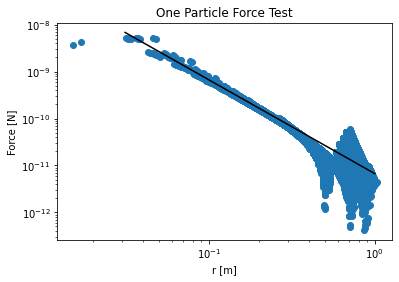

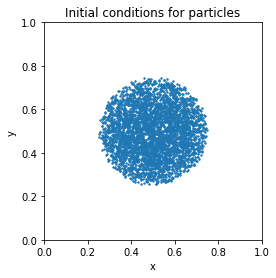

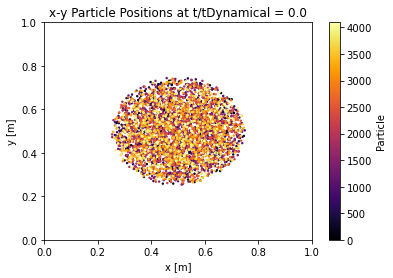

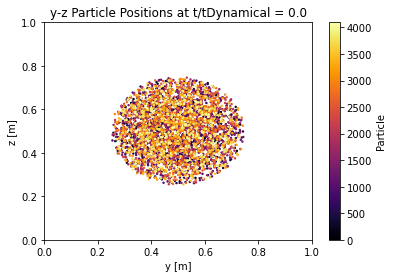

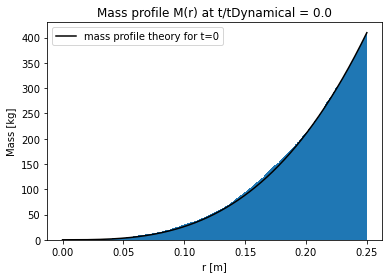

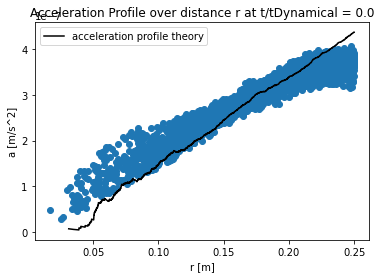

<ipython-input-11-f832ac4722b3>:90: RuntimeWarning: divide by zero encountered in double_scalars
  dt = lamnda*(min(l/vmax, (l/amax)**0.5))


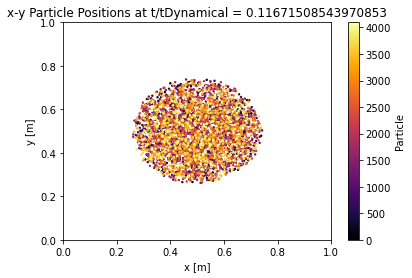

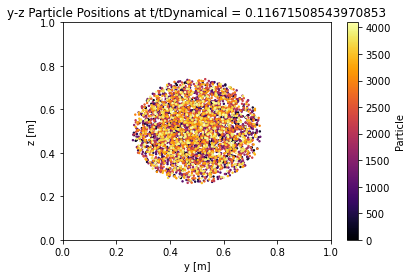

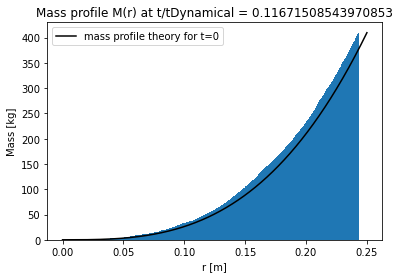

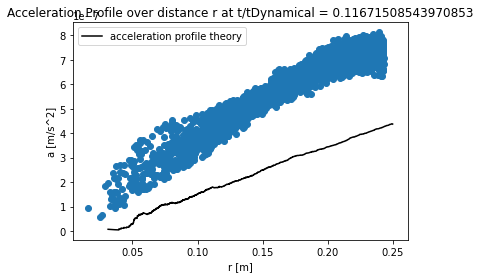

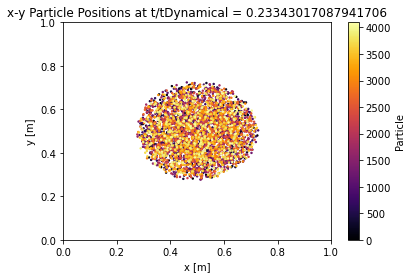

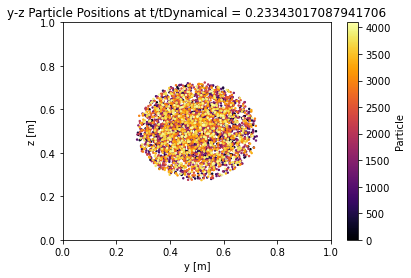

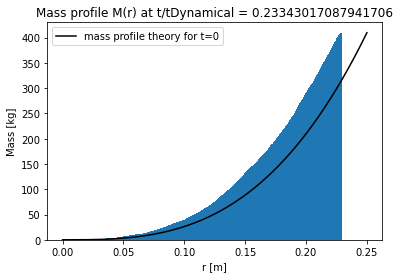

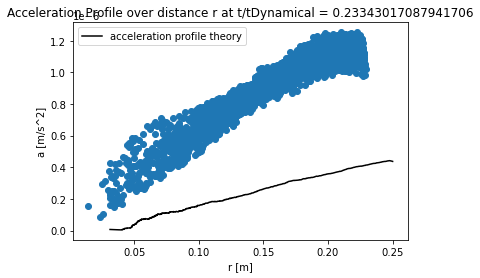

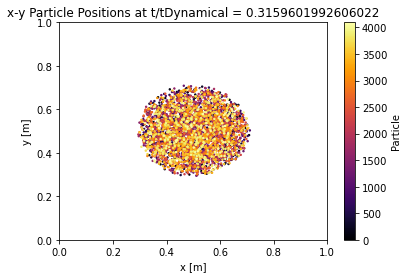

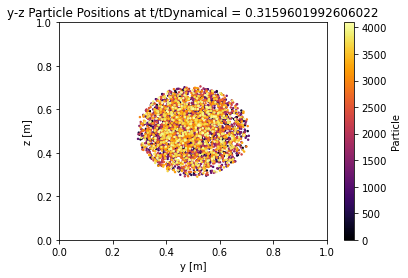

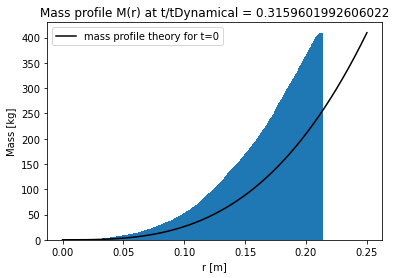

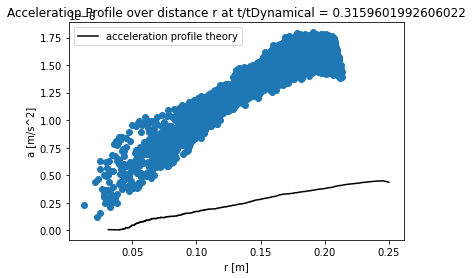

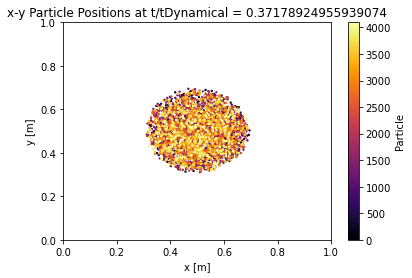

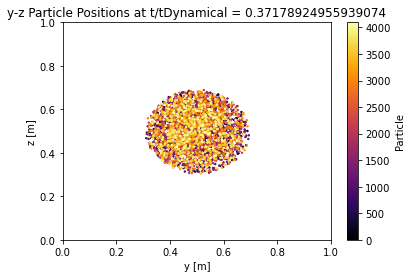

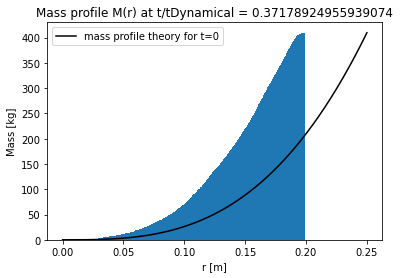

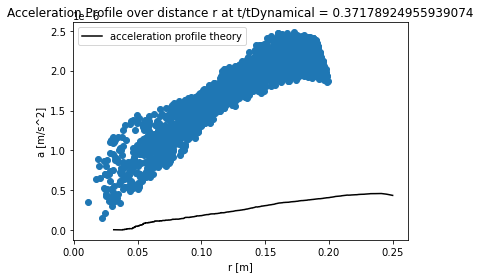

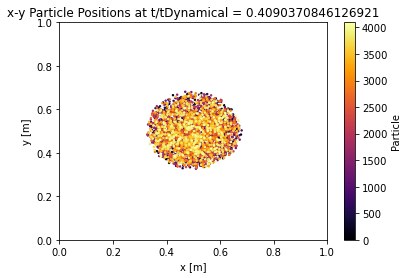

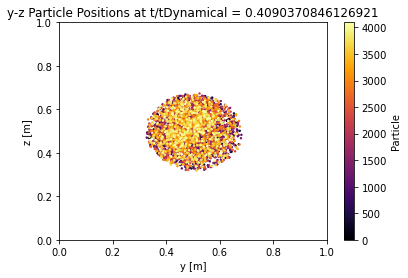

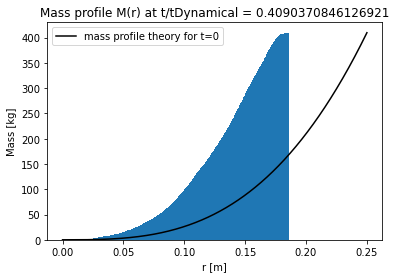

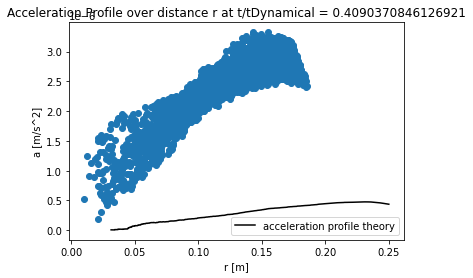

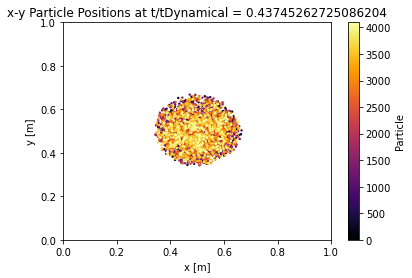

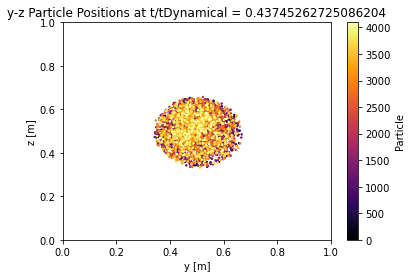

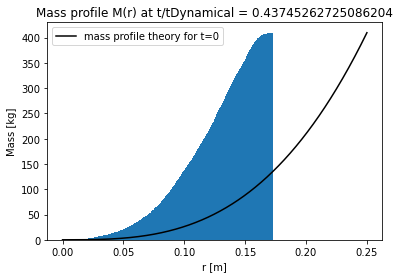

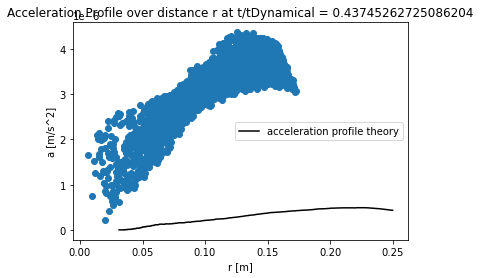

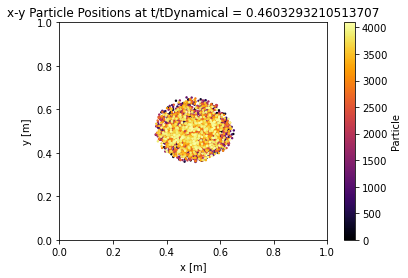

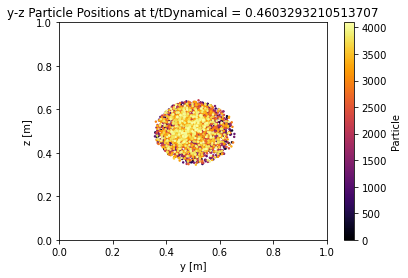

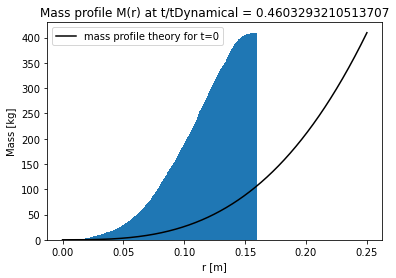

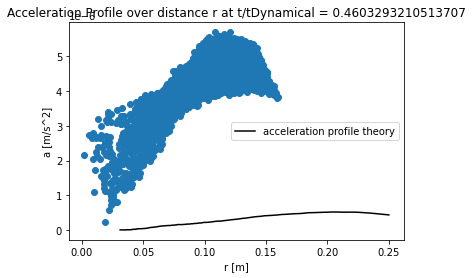

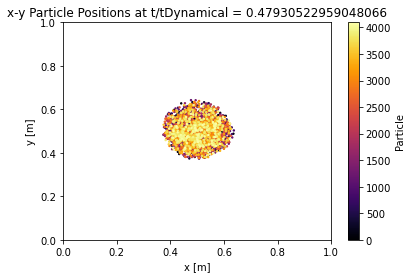

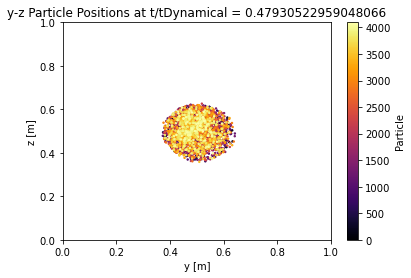

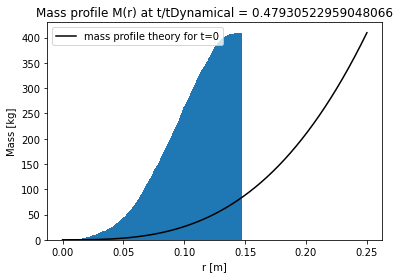

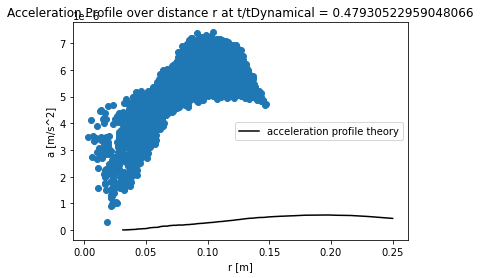

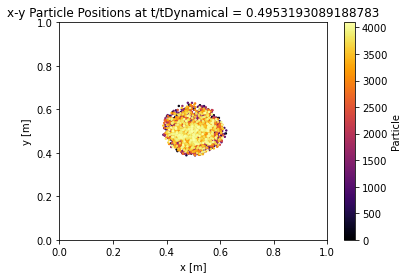

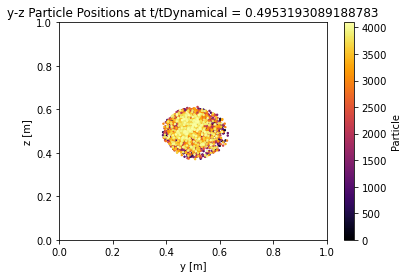

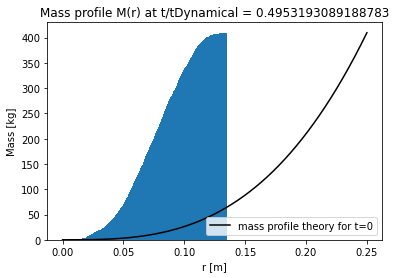

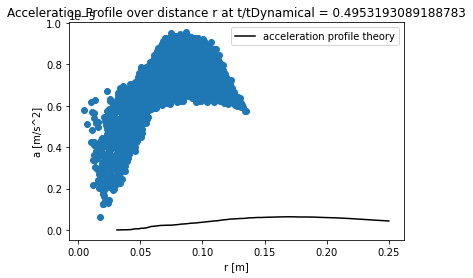

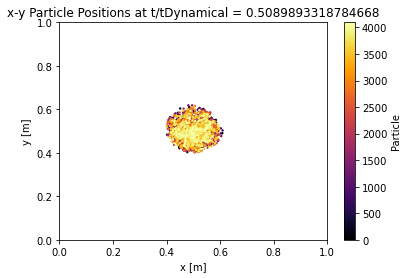

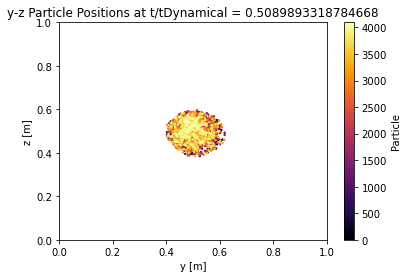

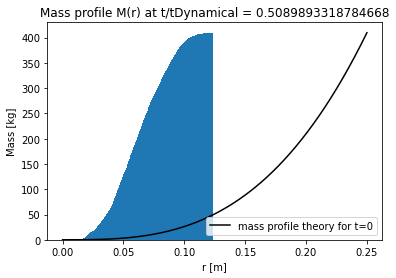

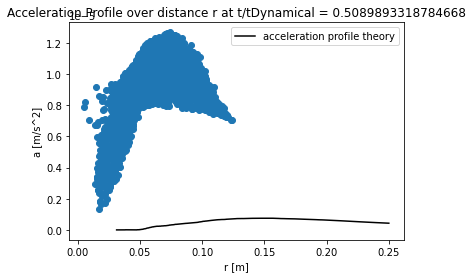

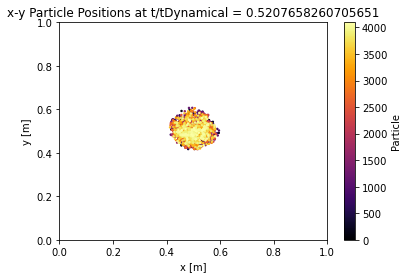

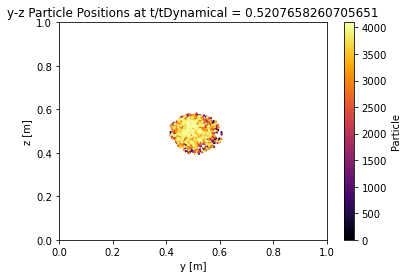

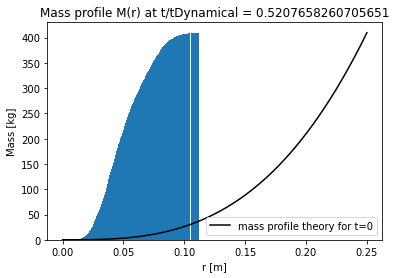

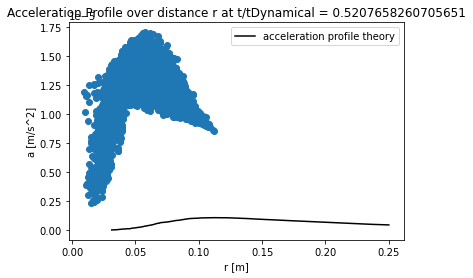

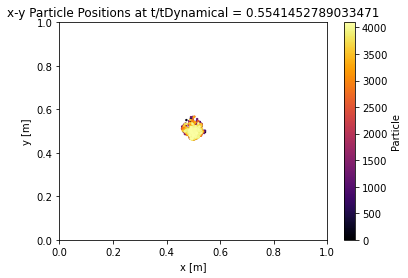

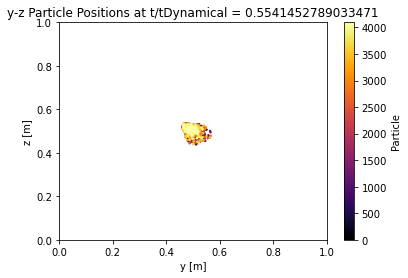

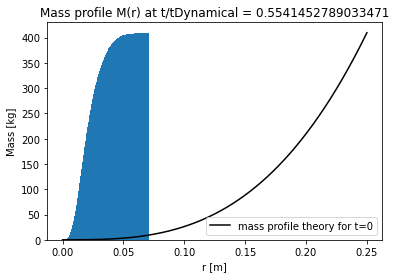

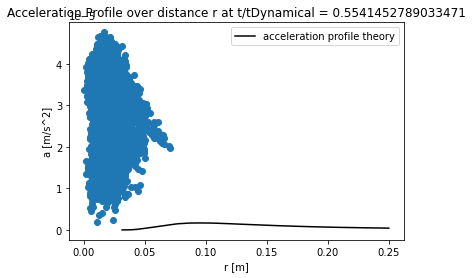

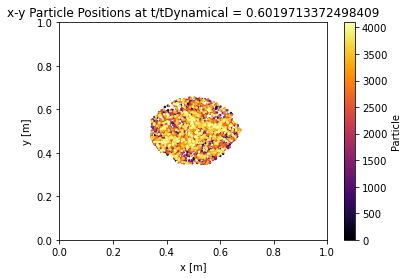

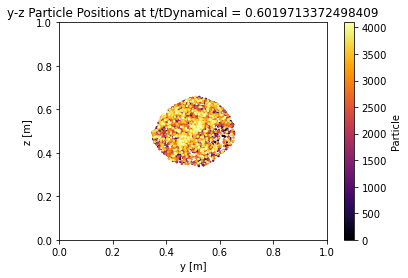

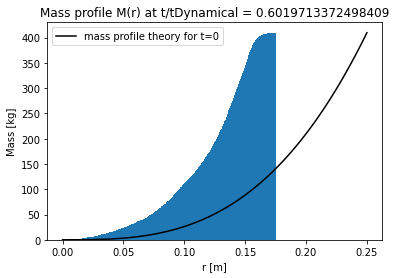

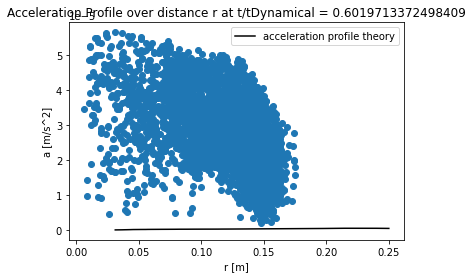

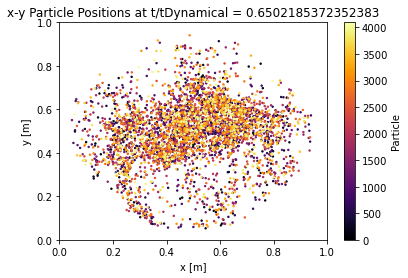

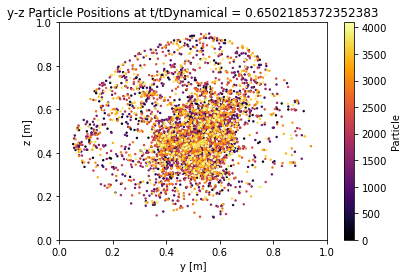

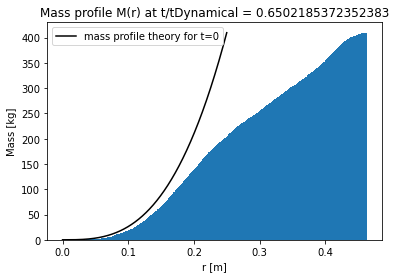

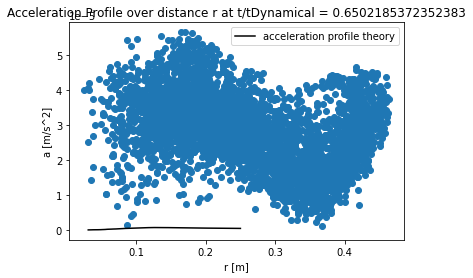

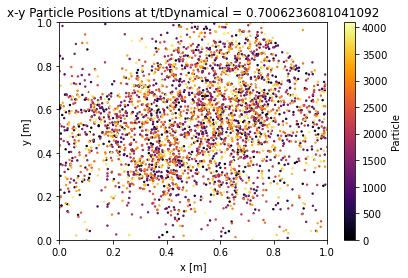

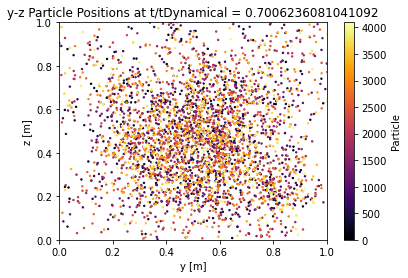

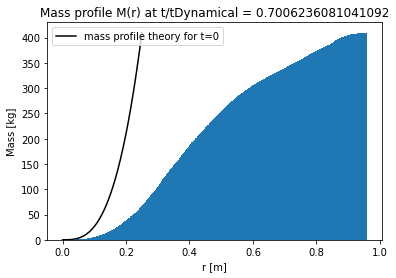

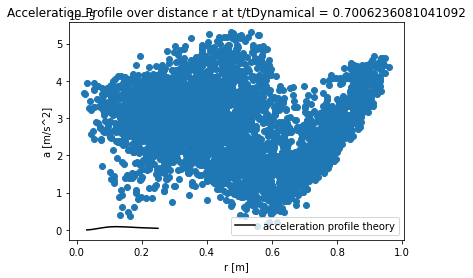

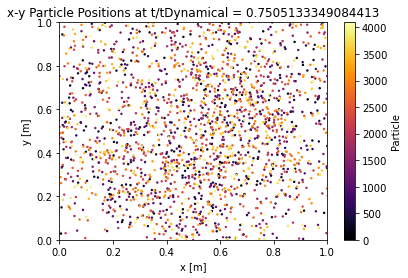

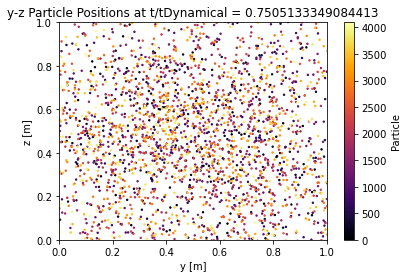

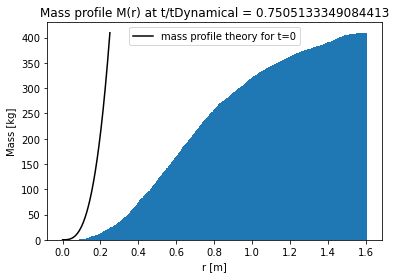

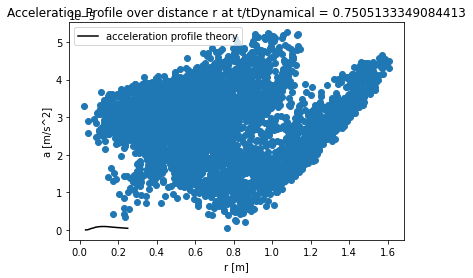

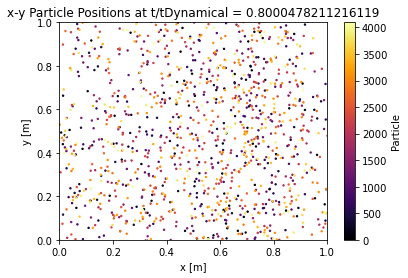

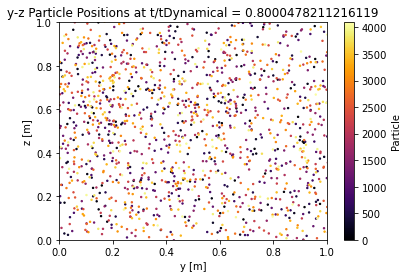

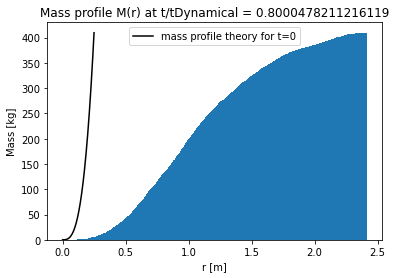

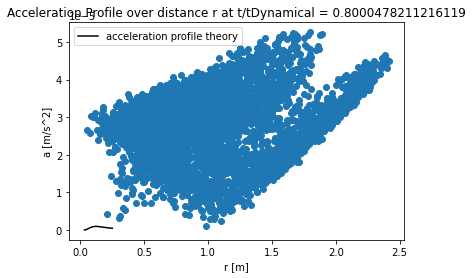

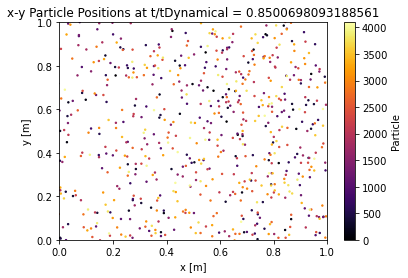

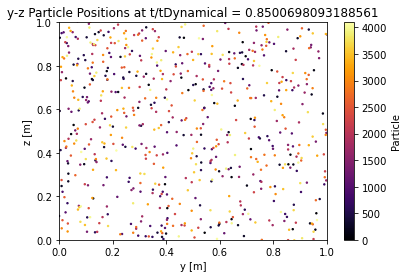

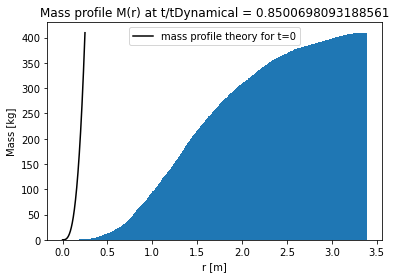

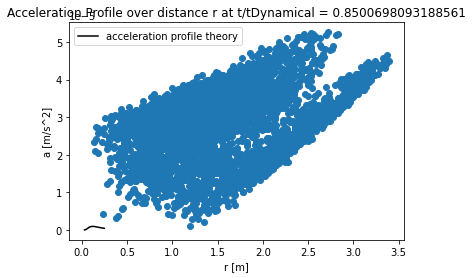

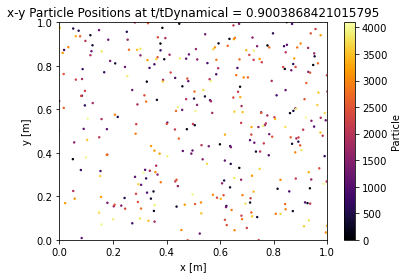

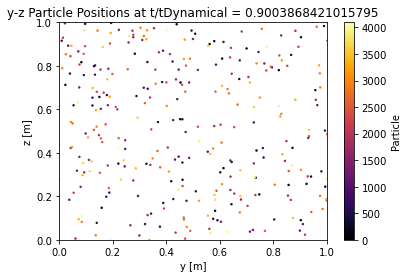

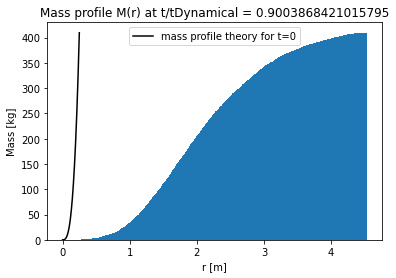

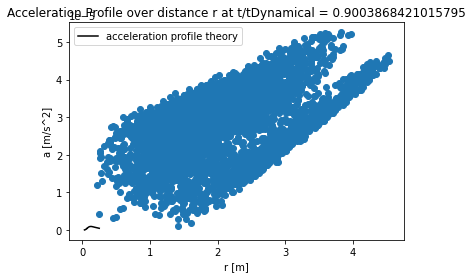

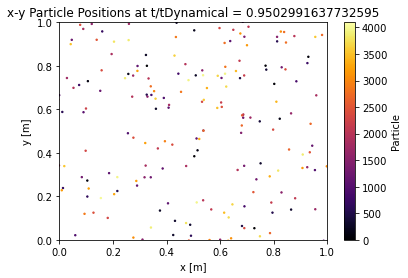

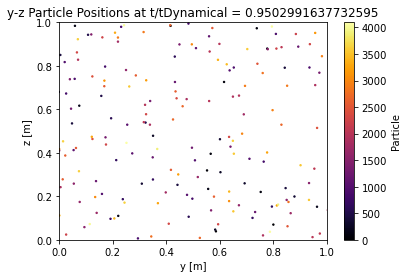

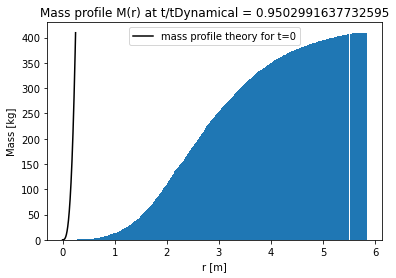

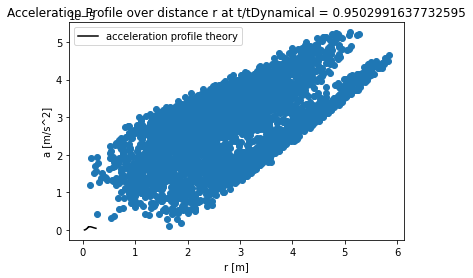

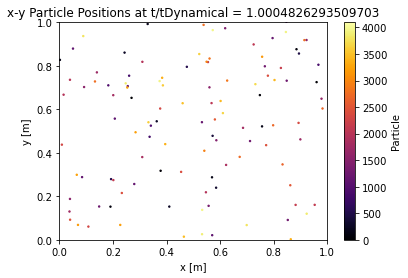

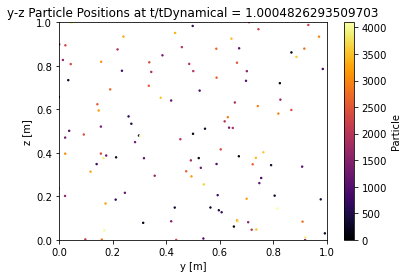

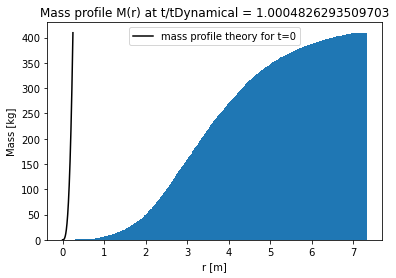

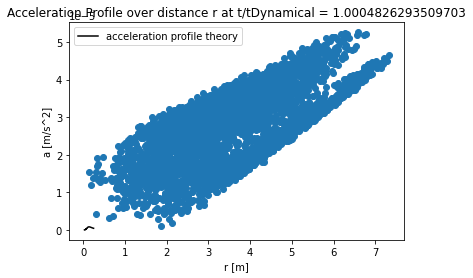

In [12]:
# Initialize constants
Np = 1 # number of particles (Start at 1 for one particle test)
Nc = 32 # cells per length in cartesian mesh
L = 1 # length of box [m]
l = L/Nc # length of each cell
R = L/4 # radius of sphere [m]
G = 6.67e-11 # Gravitational constant [kg/m^3*s^2]
mp = 0.1 # mass of particles [kg]
lamnda = 0.5 # factor for adaptive time step
t0 = 0.0
totalMass = Np*mp
tDynamical = ((np.pi**2 * R**3)/(4*G*totalMass))**0.5

# One particle test
oneParticleTest()

# Initialize for full simulation
Np = 16**3 # number of particles
totalMass = Np*mp
tDynamical = ((np.pi**2 * R**3)/(4*G*totalMass))**0.5

# Function calls
NewtonSolver(t0, tDynamical)

## Discussion

#### The cold collapse of the system begins with all particles having zero velocity. The outermost layer of particles experience the highest acceleration inwards toward the center of the sphere. Each layer continuing inwards also feels an acelleration towards the center, but less so, due to the gravitational force experienced due to the outer layers, which is radially outward. As seen in the simulation, the particles will continue to accelerate inwards as time progresses from the initial time. With each time step, the center of mass at the center of the sphere exerts a stronger gravitational force on the outer layers. Based off of my simulation, the smallest size of the system occurs at a t/tDynamical of 0.55, much earlier than the theoretical characteristic time scale of the dynamical time. This is due to the fact that the dynamical time is the time that it takes a test particle to call fo the center if the mass distribution was static. In this simulation the mass distribution is not static, it also evolves with time, and causes the system to collapse before tDynamical. The Particle Mesh code is a good approximation for solving Poisson's equation, but it is not as accurate as the particle-particle method that calculates the net force on a particle by directly summing the force contributions of every other particle in the system. The particle-particle method is much slower however, which makes the particle-mesh method a valid and practical method for N-body simulations. 

#### I had to run the simulation on intermediate parameters, anything above what I have now was taking over several hours to run even halfway. Feel free to change the Np parameter to 32^3 and Nc to 128. I also wanted to thank Professor Trac and the TA for the semester, this has been a fantastic class and this final project is something I am very proud to have completed! :)